In [26]:
# GPU memory usage
if torch.cuda.is_available():
    print("GPU Memory Summary:")
    print("=" * 70)
    print(f"Allocated: {torch.cuda.memory_allocated(0) / 1024**3:.2f} GB")
    print(f"Reserved:  {torch.cuda.memory_reserved(0) / 1024**3:.2f} GB")
    print(f"Max Allocated: {torch.cuda.max_memory_allocated(0) / 1024**3:.2f} GB")
    print("=" * 70)
    
    # Clear cache
    torch.cuda.empty_cache()
    print("GPU cache cleared!")

print("\n🎉 Training pipeline completed successfully!")
print("\nGenerated files:")
print("  - best_model.pth (best model checkpoint)")
print("  - chest_xray_cnn_final.pth (final model with metadata)")
print("  - training_history.png (training curves)")
print("  - confusion_matrix.png (confusion matrix)")
print("  - sample_predictions.png (sample predictions)")
print("  - classification_report.txt (detailed metrics)")

GPU Memory Summary:
Allocated: 3.35 GB
Reserved:  5.12 GB
Max Allocated: 6.26 GB
GPU cache cleared!

🎉 Training pipeline completed successfully!

Generated files:
  - best_model.pth (best model checkpoint)
  - chest_xray_cnn_final.pth (final model with metadata)
  - training_history.png (training curves)
  - confusion_matrix.png (confusion matrix)
  - sample_predictions.png (sample predictions)
  - classification_report.txt (detailed metrics)


## 16. GPU Utilization Summary

In [25]:
# Save complete model
torch.save({
    'model_state_dict': model.state_dict(),
    'class_names': class_names,
    'config': {
        'num_classes': config.num_classes,
        'img_size': config.img_size,
    },
    'test_accuracy': test_acc,
    'history': history
}, 'chest_xray_cnn_final.pth')

print("Final model saved as 'chest_xray_cnn_final.pth'")
print("\nModel Summary:")
print(f"  Total parameters: {total_params:,}")
print(f"  Test accuracy: {test_acc:.2f}%")
print(f"  Classes: {class_names}")

Final model saved as 'chest_xray_cnn_final.pth'

Model Summary:
  Total parameters: 125,884,483
  Test accuracy: 75.24%
  Classes: ['normal', 'pneumonia', 'tuberculosis']


## 15. Save Final Model

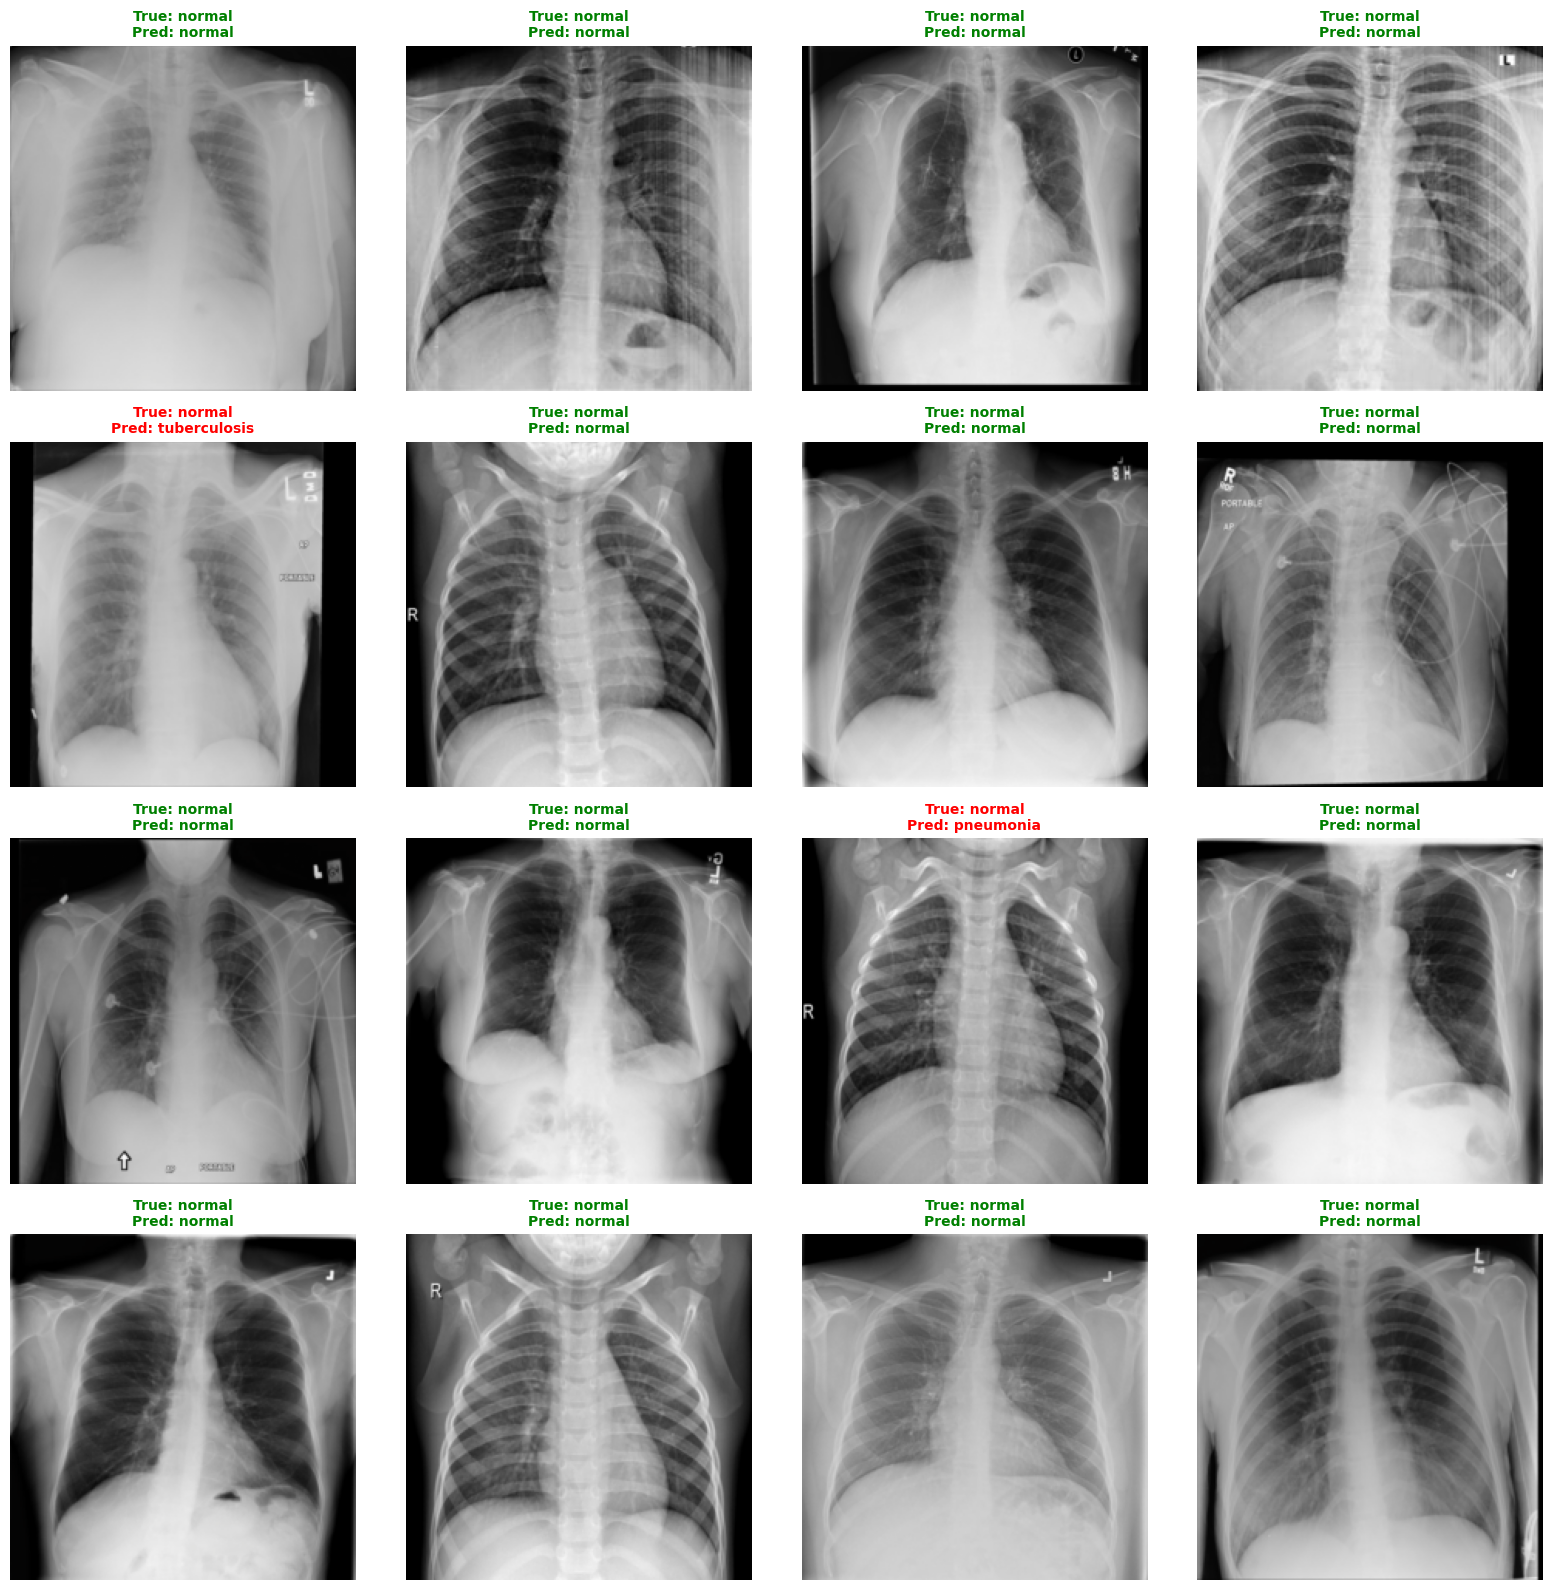

Sample predictions visualized!


In [24]:
def denormalize(tensor):
    """Denormalize image for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return tensor * std + mean

# Get a batch from test set
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(config.device)
labels = labels.to(config.device)

# Get predictions
model.eval()
with torch.no_grad():
    with torch.cuda.amp.autocast():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

# Plot sample predictions
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
axes = axes.ravel()

for idx in range(16):
    if idx < len(images):
        img = denormalize(images[idx].cpu())
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
        
        true_label = class_names[labels[idx]]
        pred_label = class_names[predicted[idx]]
        
        color = 'green' if labels[idx] == predicted[idx] else 'red'
        
        axes[idx].imshow(img)
        axes[idx].axis('off')
        axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}', 
                           color=color, fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Sample predictions visualized!")

## 14. Visualize Sample Predictions

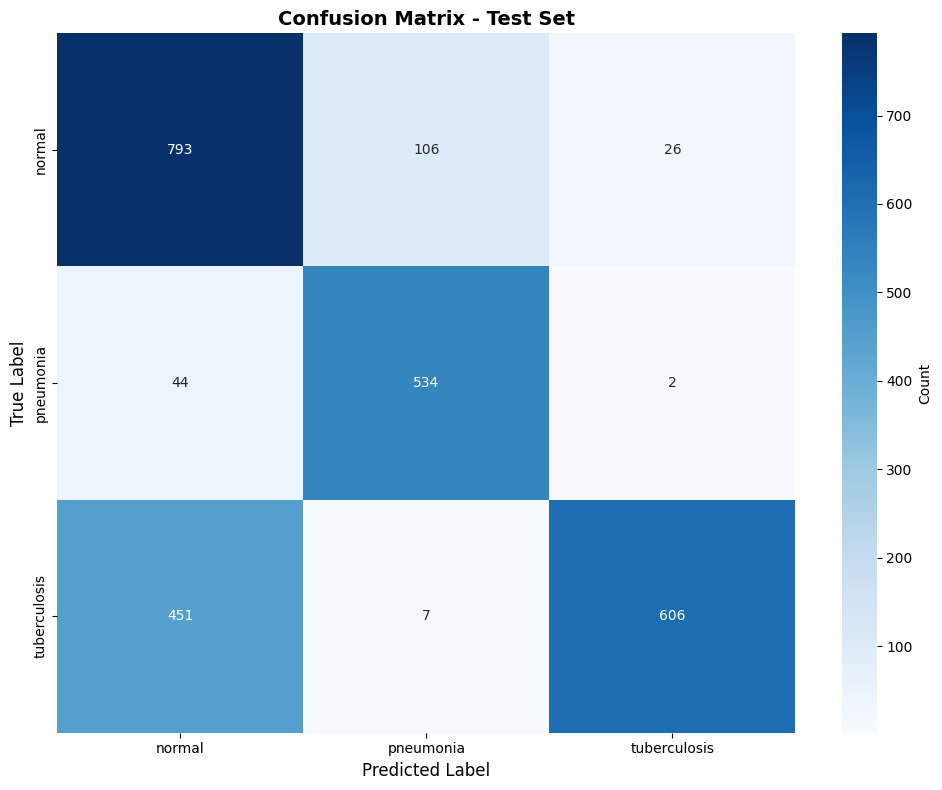


Per-class accuracy:
  normal: 85.73%
  pneumonia: 92.07%
  tuberculosis: 56.95%


In [23]:
# Generate and plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate per-class accuracy
print("\nPer-class accuracy:")
for i, class_name in enumerate(class_names):
    class_acc = 100.0 * cm[i, i] / cm[i].sum()
    print(f"  {class_name}: {class_acc:.2f}%")

## 13. Confusion Matrix

In [22]:
# Generate classification report
report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
print("\nClassification Report:")
print("=" * 70)
print(report)

# Save report to file
with open('classification_report.txt', 'w') as f:
    f.write(report)
print("Classification report saved to 'classification_report.txt'")


Classification Report:
              precision    recall  f1-score   support

      normal     0.6157    0.8573    0.7167       925
   pneumonia     0.8253    0.9207    0.8704       580
tuberculosis     0.9558    0.5695    0.7138      1064

    accuracy                         0.7524      2569
   macro avg     0.7990    0.7825    0.7670      2569
weighted avg     0.8039    0.7524    0.7502      2569

Classification report saved to 'classification_report.txt'


## 12. Classification Report

In [21]:
# Load best model
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Best model loaded from epoch {checkpoint['epoch']+1}")
print(f"Best validation loss: {checkpoint['val_loss']:.4f}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

# Evaluate on test set
model.eval()
all_preds = []
all_labels = []
test_loss = 0.0

print("\nEvaluating on test set...")
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        inputs = inputs.to(config.device, non_blocking=True)
        labels = labels.to(config.device, non_blocking=True)
        
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        test_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_loss = test_loss / len(test_dataset)
test_acc = 100.0 * np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

print(f"\nTest Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")

Best model loaded from epoch 49
Best validation loss: 0.4472
Best validation accuracy: 75.30%

Evaluating on test set...


100%|██████████| 41/41 [00:08<00:00,  5.08it/s]


Test Results:
Test Loss: 0.4511
Test Accuracy: 75.24%


## 11. Load Best Model and Evaluate on Test Set

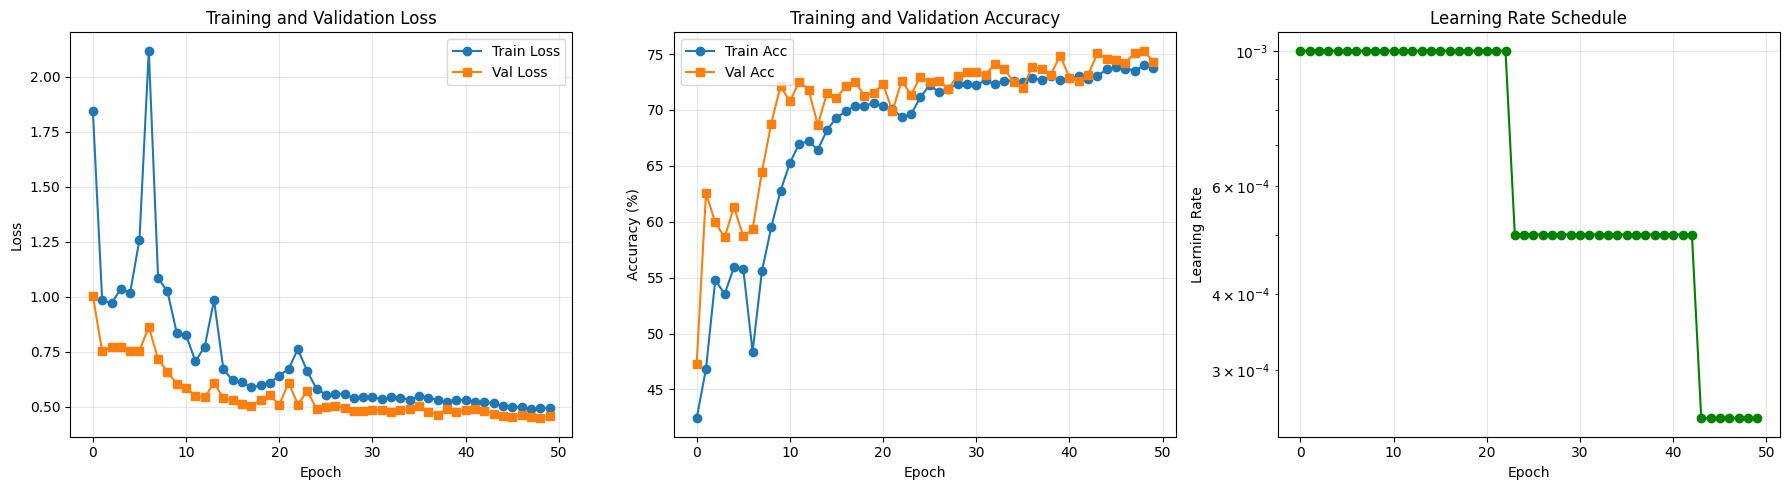

Training history plots saved!


In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot loss
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot accuracy
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot learning rate
axes[2].plot(history['lr'], marker='o', color='green')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate Schedule')
axes[2].set_yscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plots saved!")

## 10. Plot Training History

In [19]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'lr': []
}

# Early stopping variables
best_val_loss = float('inf')
best_val_acc = 0.0
patience_counter = 0
best_model_path = 'best_model.pth'

print(f"Starting training for {config.num_epochs} epochs...")
print(f"Training on: {config.device}")
print("=" * 70)

start_time = time.time()

for epoch in range(config.num_epochs):
    epoch_start = time.time()
    
    print(f"\nEpoch [{epoch+1}/{config.num_epochs}]")
    print("-" * 70)
    
    # Train
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, scaler, config.device
    )
    
    # Validate
    val_loss, val_acc = validate_epoch(
        model, val_loader, criterion, config.device
    )
    
    # Update learning rate
    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)
    
    epoch_time = time.time() - epoch_start
    
    # Print epoch summary
    print(f"\nEpoch Summary:")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.2f}%")
    print(f"  Learning Rate: {current_lr:.6f}")
    print(f"  Epoch Time: {epoch_time:.2f}s")
    
    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_loss,
            'val_acc': val_acc,
        }, best_model_path)
        print(f"  ✓ Best model saved! (Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%)")
    else:
        patience_counter += 1
        print(f"  Early stopping: {patience_counter}/{config.early_stopping_patience}")
    
    # Early stopping
    if patience_counter >= config.early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs!")
        break
    
    # Clear cache periodically
    if (epoch + 1) % 5 == 0:
        torch.cuda.empty_cache()

total_time = time.time() - start_time
print("\n" + "=" * 70)
print(f"Training completed in {total_time/60:.2f} minutes")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_acc:.2f}%")
print("=" * 70)

Starting training for 50 epochs...
Training on: cuda

Epoch [1/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:08<00:00,  4.76it/s, loss=0.9576, acc=47.28%]



Epoch Summary:
  Train Loss: 1.8439 | Train Acc: 42.42%
  Val Loss:   1.0050 | Val Acc:   47.28%
  Learning Rate: 0.001000
  Epoch Time: 134.93s
  ✓ Best model saved! (Val Loss: 1.0050, Val Acc: 47.28%)

Epoch [2/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 1.0050, Val Acc: 47.28%)

Epoch [2/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.43it/s, loss=0.6150, acc=62.55%]




Epoch Summary:
  Train Loss: 0.9833 | Train Acc: 46.84%
  Val Loss:   0.7517 | Val Acc:   62.55%
  Learning Rate: 0.001000
  Epoch Time: 87.38s
  ✓ Best model saved! (Val Loss: 0.7517, Val Acc: 62.55%)

Epoch [3/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.7517, Val Acc: 62.55%)

Epoch [3/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.20it/s, loss=0.8441, acc=59.94%]



Epoch Summary:
  Train Loss: 0.9709 | Train Acc: 54.82%
  Val Loss:   0.7721 | Val Acc:   59.94%
  Learning Rate: 0.001000
  Epoch Time: 87.84s
  Early stopping: 1/10

Epoch [4/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.34it/s, loss=0.7653, acc=58.60%]



Epoch Summary:
  Train Loss: 1.0360 | Train Acc: 53.53%
  Val Loss:   0.7701 | Val Acc:   58.60%
  Learning Rate: 0.001000
  Epoch Time: 87.43s
  Early stopping: 2/10

Epoch [5/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.49it/s, loss=0.8390, acc=61.33%]



Epoch Summary:
  Train Loss: 1.0193 | Train Acc: 55.92%
  Val Loss:   0.7521 | Val Acc:   61.33%
  Learning Rate: 0.001000
  Epoch Time: 87.52s
  Early stopping: 3/10

Epoch [6/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.40it/s, loss=0.5336, acc=58.68%]



Epoch Summary:
  Train Loss: 1.2598 | Train Acc: 55.78%
  Val Loss:   0.7542 | Val Acc:   58.68%
  Learning Rate: 0.001000
  Epoch Time: 87.59s
  Early stopping: 4/10

Epoch [7/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.43it/s, loss=0.8246, acc=59.31%]



Epoch Summary:
  Train Loss: 2.1188 | Train Acc: 48.38%
  Val Loss:   0.8640 | Val Acc:   59.31%
  Learning Rate: 0.001000
  Epoch Time: 87.63s
  Early stopping: 5/10

Epoch [8/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.41it/s, loss=0.6839, acc=64.44%]




Epoch Summary:
  Train Loss: 1.0845 | Train Acc: 55.56%
  Val Loss:   0.7155 | Val Acc:   64.44%
  Learning Rate: 0.001000
  Epoch Time: 87.28s
  ✓ Best model saved! (Val Loss: 0.7155, Val Acc: 64.44%)

Epoch [9/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.7155, Val Acc: 64.44%)

Epoch [9/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.20it/s, loss=0.5694, acc=68.78%]




Epoch Summary:
  Train Loss: 1.0246 | Train Acc: 59.50%
  Val Loss:   0.6601 | Val Acc:   68.78%
  Learning Rate: 0.001000
  Epoch Time: 87.79s
  ✓ Best model saved! (Val Loss: 0.6601, Val Acc: 68.78%)

Epoch [10/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.6601, Val Acc: 68.78%)

Epoch [10/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.29it/s, loss=0.5661, acc=72.14%]




Epoch Summary:
  Train Loss: 0.8354 | Train Acc: 62.77%
  Val Loss:   0.6037 | Val Acc:   72.14%
  Learning Rate: 0.001000
  Epoch Time: 87.74s
  ✓ Best model saved! (Val Loss: 0.6037, Val Acc: 72.14%)

Epoch [11/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.6037, Val Acc: 72.14%)

Epoch [11/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.25it/s, loss=0.6715, acc=70.76%]




Epoch Summary:
  Train Loss: 0.8263 | Train Acc: 65.25%
  Val Loss:   0.5852 | Val Acc:   70.76%
  Learning Rate: 0.001000
  Epoch Time: 87.83s
  ✓ Best model saved! (Val Loss: 0.5852, Val Acc: 70.76%)

Epoch [12/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.5852, Val Acc: 70.76%)

Epoch [12/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.39it/s, loss=0.5640, acc=72.53%]




Epoch Summary:
  Train Loss: 0.7060 | Train Acc: 66.97%
  Val Loss:   0.5499 | Val Acc:   72.53%
  Learning Rate: 0.001000
  Epoch Time: 87.58s
  ✓ Best model saved! (Val Loss: 0.5499, Val Acc: 72.53%)

Epoch [13/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.5499, Val Acc: 72.53%)

Epoch [13/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.40it/s, loss=0.5607, acc=71.82%]




Epoch Summary:
  Train Loss: 0.7735 | Train Acc: 67.19%
  Val Loss:   0.5427 | Val Acc:   71.82%
  Learning Rate: 0.001000
  Epoch Time: 87.35s
  ✓ Best model saved! (Val Loss: 0.5427, Val Acc: 71.82%)

Epoch [14/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.5427, Val Acc: 71.82%)

Epoch [14/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.37it/s, loss=0.6110, acc=68.67%]



Epoch Summary:
  Train Loss: 0.9847 | Train Acc: 66.45%
  Val Loss:   0.6094 | Val Acc:   68.67%
  Learning Rate: 0.001000
  Epoch Time: 87.61s
  Early stopping: 1/10

Epoch [15/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.41it/s, loss=0.6357, acc=71.55%]




Epoch Summary:
  Train Loss: 0.6712 | Train Acc: 68.21%
  Val Loss:   0.5385 | Val Acc:   71.55%
  Learning Rate: 0.001000
  Epoch Time: 87.48s
  ✓ Best model saved! (Val Loss: 0.5385, Val Acc: 71.55%)

Epoch [16/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.5385, Val Acc: 71.55%)

Epoch [16/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.40it/s, loss=0.5655, acc=71.07%]




Epoch Summary:
  Train Loss: 0.6194 | Train Acc: 69.31%
  Val Loss:   0.5313 | Val Acc:   71.07%
  Learning Rate: 0.001000
  Epoch Time: 87.54s
  ✓ Best model saved! (Val Loss: 0.5313, Val Acc: 71.07%)

Epoch [17/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.5313, Val Acc: 71.07%)

Epoch [17/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s, loss=0.5347, acc=72.10%]




Epoch Summary:
  Train Loss: 0.6102 | Train Acc: 69.88%
  Val Loss:   0.5138 | Val Acc:   72.10%
  Learning Rate: 0.001000
  Epoch Time: 87.75s
  ✓ Best model saved! (Val Loss: 0.5138, Val Acc: 72.10%)

Epoch [18/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.5138, Val Acc: 72.10%)

Epoch [18/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.40it/s, loss=0.4826, acc=72.53%]




Epoch Summary:
  Train Loss: 0.5878 | Train Acc: 70.38%
  Val Loss:   0.5054 | Val Acc:   72.53%
  Learning Rate: 0.001000
  Epoch Time: 87.53s
  ✓ Best model saved! (Val Loss: 0.5054, Val Acc: 72.53%)

Epoch [19/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.5054, Val Acc: 72.53%)

Epoch [19/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.57it/s, loss=0.5457, acc=71.27%]



Epoch Summary:
  Train Loss: 0.5977 | Train Acc: 70.35%
  Val Loss:   0.5299 | Val Acc:   71.27%
  Learning Rate: 0.001000
  Epoch Time: 87.25s
  Early stopping: 1/10

Epoch [20/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.41it/s, loss=0.4530, acc=71.55%]



Epoch Summary:
  Train Loss: 0.6099 | Train Acc: 70.62%
  Val Loss:   0.5524 | Val Acc:   71.55%
  Learning Rate: 0.001000
  Epoch Time: 87.55s
  Early stopping: 2/10

Epoch [21/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.36it/s, loss=0.5300, acc=72.34%]



Epoch Summary:
  Train Loss: 0.6401 | Train Acc: 70.34%
  Val Loss:   0.5088 | Val Acc:   72.34%
  Learning Rate: 0.001000
  Epoch Time: 87.61s
  Early stopping: 3/10

Epoch [22/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.30it/s, loss=0.3667, acc=69.89%]



Epoch Summary:
  Train Loss: 0.6725 | Train Acc: 70.09%
  Val Loss:   0.6097 | Val Acc:   69.89%
  Learning Rate: 0.001000
  Epoch Time: 87.68s
  Early stopping: 4/10

Epoch [23/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.47it/s, loss=0.5495, acc=72.61%]



Epoch Summary:
  Train Loss: 0.7620 | Train Acc: 69.34%
  Val Loss:   0.5099 | Val Acc:   72.61%
  Learning Rate: 0.001000
  Epoch Time: 87.60s
  Early stopping: 5/10

Epoch [24/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.39it/s, loss=0.3791, acc=71.35%]



Epoch Summary:
  Train Loss: 0.6603 | Train Acc: 69.63%
  Val Loss:   0.5718 | Val Acc:   71.35%
  Learning Rate: 0.000500
  Epoch Time: 87.62s
  Early stopping: 6/10

Epoch [25/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.42it/s, loss=0.5149, acc=72.97%]




Epoch Summary:
  Train Loss: 0.5817 | Train Acc: 71.12%
  Val Loss:   0.4909 | Val Acc:   72.97%
  Learning Rate: 0.000500
  Epoch Time: 87.49s
  ✓ Best model saved! (Val Loss: 0.4909, Val Acc: 72.97%)

Epoch [26/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.4909, Val Acc: 72.97%)

Epoch [26/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.32it/s, loss=0.5757, acc=72.49%]



Epoch Summary:
  Train Loss: 0.5552 | Train Acc: 72.23%
  Val Loss:   0.4974 | Val Acc:   72.49%
  Learning Rate: 0.000500
  Epoch Time: 87.44s
  Early stopping: 1/10

Epoch [27/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.31it/s, loss=0.5304, acc=72.61%]



Epoch Summary:
  Train Loss: 0.5580 | Train Acc: 71.57%
  Val Loss:   0.5036 | Val Acc:   72.61%
  Learning Rate: 0.000500
  Epoch Time: 87.55s
  Early stopping: 2/10

Epoch [28/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.41it/s, loss=0.5513, acc=71.90%]



Epoch Summary:
  Train Loss: 0.5594 | Train Acc: 71.85%
  Val Loss:   0.4957 | Val Acc:   71.90%
  Learning Rate: 0.000500
  Epoch Time: 87.86s
  Early stopping: 3/10

Epoch [29/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.49it/s, loss=0.4934, acc=73.05%]




Epoch Summary:
  Train Loss: 0.5379 | Train Acc: 72.34%
  Val Loss:   0.4826 | Val Acc:   73.05%
  Learning Rate: 0.000500
  Epoch Time: 87.59s
  ✓ Best model saved! (Val Loss: 0.4826, Val Acc: 73.05%)

Epoch [30/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.4826, Val Acc: 73.05%)

Epoch [30/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.45it/s, loss=0.4899, acc=73.36%]



Epoch Summary:
  Train Loss: 0.5423 | Train Acc: 72.33%
  Val Loss:   0.4827 | Val Acc:   73.36%
  Learning Rate: 0.000500
  Epoch Time: 87.37s
  Early stopping: 1/10

Epoch [31/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.54it/s, loss=0.4582, acc=73.40%]



Epoch Summary:
  Train Loss: 0.5452 | Train Acc: 72.22%
  Val Loss:   0.4838 | Val Acc:   73.40%
  Learning Rate: 0.000500
  Epoch Time: 87.38s
  Early stopping: 2/10

Epoch [32/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.43it/s, loss=0.5079, acc=73.16%]



Epoch Summary:
  Train Loss: 0.5342 | Train Acc: 72.65%
  Val Loss:   0.4836 | Val Acc:   73.16%
  Learning Rate: 0.000500
  Epoch Time: 87.76s
  Early stopping: 3/10

Epoch [33/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.48it/s, loss=0.4175, acc=74.11%]




Epoch Summary:
  Train Loss: 0.5420 | Train Acc: 72.30%
  Val Loss:   0.4747 | Val Acc:   74.11%
  Learning Rate: 0.000500
  Epoch Time: 87.48s
  ✓ Best model saved! (Val Loss: 0.4747, Val Acc: 74.11%)

Epoch [34/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.4747, Val Acc: 74.11%)

Epoch [34/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.46it/s, loss=0.4289, acc=73.68%]



Epoch Summary:
  Train Loss: 0.5410 | Train Acc: 72.60%
  Val Loss:   0.4844 | Val Acc:   73.68%
  Learning Rate: 0.000500
  Epoch Time: 87.42s
  Early stopping: 1/10

Epoch [35/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.39it/s, loss=0.5488, acc=72.49%]



Epoch Summary:
  Train Loss: 0.5318 | Train Acc: 72.63%
  Val Loss:   0.4899 | Val Acc:   72.49%
  Learning Rate: 0.000500
  Epoch Time: 87.47s
  Early stopping: 2/10

Epoch [36/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.45it/s, loss=0.5582, acc=71.94%]



Epoch Summary:
  Train Loss: 0.5492 | Train Acc: 72.50%
  Val Loss:   0.5048 | Val Acc:   71.94%
  Learning Rate: 0.000500
  Epoch Time: 87.51s
  Early stopping: 3/10

Epoch [37/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.53it/s, loss=0.4641, acc=73.88%]



Epoch Summary:
  Train Loss: 0.5402 | Train Acc: 72.84%
  Val Loss:   0.4777 | Val Acc:   73.88%
  Learning Rate: 0.000500
  Epoch Time: 87.31s
  Early stopping: 4/10

Epoch [38/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.46it/s, loss=0.3492, acc=73.64%]




Epoch Summary:
  Train Loss: 0.5317 | Train Acc: 72.68%
  Val Loss:   0.4642 | Val Acc:   73.64%
  Learning Rate: 0.000500
  Epoch Time: 87.17s
  ✓ Best model saved! (Val Loss: 0.4642, Val Acc: 73.64%)

Epoch [39/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.4642, Val Acc: 73.64%)

Epoch [39/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.52it/s, loss=0.5444, acc=73.16%]



Epoch Summary:
  Train Loss: 0.5223 | Train Acc: 72.99%
  Val Loss:   0.4893 | Val Acc:   73.16%
  Learning Rate: 0.000500
  Epoch Time: 87.25s
  Early stopping: 1/10

Epoch [40/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.44it/s, loss=0.4205, acc=74.86%]



Epoch Summary:
  Train Loss: 0.5328 | Train Acc: 72.64%
  Val Loss:   0.4775 | Val Acc:   74.86%
  Learning Rate: 0.000500
  Epoch Time: 87.61s
  Early stopping: 2/10

Epoch [41/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.44it/s, loss=0.4426, acc=72.89%]



Epoch Summary:
  Train Loss: 0.5290 | Train Acc: 72.86%
  Val Loss:   0.4850 | Val Acc:   72.89%
  Learning Rate: 0.000500
  Epoch Time: 87.60s
  Early stopping: 3/10

Epoch [42/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.29it/s, loss=0.5063, acc=72.57%]



Epoch Summary:
  Train Loss: 0.5225 | Train Acc: 73.01%
  Val Loss:   0.4903 | Val Acc:   72.57%
  Learning Rate: 0.000500
  Epoch Time: 87.69s
  Early stopping: 4/10

Epoch [43/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.50it/s, loss=0.4588, acc=73.16%]



Epoch Summary:
  Train Loss: 0.5200 | Train Acc: 72.78%
  Val Loss:   0.4824 | Val Acc:   73.16%
  Learning Rate: 0.000500
  Epoch Time: 87.29s
  Early stopping: 5/10

Epoch [44/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.42it/s, loss=0.3943, acc=75.06%]



Epoch Summary:
  Train Loss: 0.5153 | Train Acc: 73.05%
  Val Loss:   0.4682 | Val Acc:   75.06%
  Learning Rate: 0.000250
  Epoch Time: 87.40s
  Early stopping: 6/10

Epoch [45/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.31it/s, loss=0.4239, acc=74.59%]




Epoch Summary:
  Train Loss: 0.5031 | Train Acc: 73.62%
  Val Loss:   0.4598 | Val Acc:   74.59%
  Learning Rate: 0.000250
  Epoch Time: 87.68s
  ✓ Best model saved! (Val Loss: 0.4598, Val Acc: 74.59%)

Epoch [46/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.4598, Val Acc: 74.59%)

Epoch [46/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.51it/s, loss=0.4066, acc=74.43%]




Epoch Summary:
  Train Loss: 0.4970 | Train Acc: 73.83%
  Val Loss:   0.4539 | Val Acc:   74.43%
  Learning Rate: 0.000250
  Epoch Time: 87.14s
  ✓ Best model saved! (Val Loss: 0.4539, Val Acc: 74.43%)

Epoch [47/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.4539, Val Acc: 74.43%)

Epoch [47/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.38it/s, loss=0.4518, acc=74.23%]



Epoch Summary:
  Train Loss: 0.4974 | Train Acc: 73.70%
  Val Loss:   0.4629 | Val Acc:   74.23%
  Learning Rate: 0.000250
  Epoch Time: 87.56s
  Early stopping: 1/10

Epoch [48/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.35it/s, loss=0.4268, acc=75.10%]




Epoch Summary:
  Train Loss: 0.4905 | Train Acc: 73.51%
  Val Loss:   0.4526 | Val Acc:   75.10%
  Learning Rate: 0.000250
  Epoch Time: 87.66s
  ✓ Best model saved! (Val Loss: 0.4526, Val Acc: 75.10%)

Epoch [49/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.4526, Val Acc: 75.10%)

Epoch [49/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.45it/s, loss=0.3997, acc=75.30%]




Epoch Summary:
  Train Loss: 0.4952 | Train Acc: 73.98%
  Val Loss:   0.4472 | Val Acc:   75.30%
  Learning Rate: 0.000250
  Epoch Time: 87.46s
  ✓ Best model saved! (Val Loss: 0.4472, Val Acc: 75.30%)

Epoch [50/50]
----------------------------------------------------------------------
  ✓ Best model saved! (Val Loss: 0.4472, Val Acc: 75.30%)

Epoch [50/50]
----------------------------------------------------------------------


Validation: 100%|██████████| 40/40 [00:07<00:00,  5.34it/s, loss=0.4424, acc=74.27%]



Epoch Summary:
  Train Loss: 0.4935 | Train Acc: 73.73%
  Val Loss:   0.4579 | Val Acc:   74.27%
  Learning Rate: 0.000250
  Epoch Time: 87.48s
  Early stopping: 1/10

Training completed in 77.94 minutes
Best validation loss: 0.4472
Best validation accuracy: 75.30%


## 9. Training Loop with Early Stopping

In [18]:
def train_epoch(model, dataloader, criterion, optimizer, scaler, device):
    """Train for one epoch with GPU optimization"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Training')
    
    for inputs, labels in progress_bar:
        # Move data to GPU (non_blocking for async transfer)
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        
        # Zero gradients
        optimizer.zero_grad(set_to_none=True)  # More efficient than zero_grad()
        
        # Mixed precision forward pass
        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        # Mixed precision backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Update progress bar
        progress_bar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{100.0 * correct / total:.2f}%'
        })
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Validate the model"""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc='Validation')
    
    with torch.no_grad():
        for inputs, labels in progress_bar:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # Mixed precision inference
            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{100.0 * correct / total:.2f}%'
            })
    
    epoch_loss = running_loss / total
    epoch_acc = 100.0 * correct / total
    
    return epoch_loss, epoch_acc

print("Training and validation functions defined!")

Training and validation functions defined!


## 8. Training and Validation Functions

In [17]:
# Loss function (handles class imbalance if needed)
criterion = nn.CrossEntropyLoss()

# Optimizer with weight decay for regularization
optimizer = optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

# Learning rate scheduler - reduces LR when validation loss plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=config.lr_scheduler_factor,
    patience=config.lr_scheduler_patience,
    # verbose=True
)

# Mixed precision training for faster computation (FP16)
scaler = torch.cuda.amp.GradScaler()

print("Optimizer: Adam")
print(f"Initial learning rate: {config.learning_rate}")
print(f"Weight decay: {config.weight_decay}")
print("Mixed precision training: Enabled")

Optimizer: Adam
Initial learning rate: 0.001
Weight decay: 0.0001
Mixed precision training: Enabled


## 7. Loss Function and Optimizer

In [15]:
class ChestXRayCNN(nn.Module):
    def __init__(self, num_classes=3):
        super(ChestXRayCNN, self).__init__()
        
        # Convolutional Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )
        
        # Convolutional Block 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.25)
        )
        
        # Convolutional Block 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.3)
        )
        
        # Convolutional Block 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.3)
        )
        
        # Convolutional Block 5
        self.conv5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Dropout2d(0.3)
        )
        
        # Adaptive pooling for flexible input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((7, 7))
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 2048),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(2048, num_classes)
        )
        
        # Initialize weights
        self._initialize_weights()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.adaptive_pool(x)
        x = self.classifier(x)
        return x
    
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# Create model and move to GPU
model = ChestXRayCNN(num_classes=config.num_classes).to(config.device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model moved to: {next(model.parameters()).device}")

Total parameters: 125,884,483
Trainable parameters: 125,884,483
Model moved to: cuda:0


## 6. Custom CNN Architecture

In [14]:
# Load datasets using ImageFolder
train_dataset = ImageFolder(root=config.train_dir, transform=train_transform)
val_dataset = ImageFolder(root=config.val_dir, transform=val_test_transform)
test_dataset = ImageFolder(root=config.test_dir, transform=val_test_transform)

# Create DataLoaders with GPU optimization
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory,
    prefetch_factor=config.prefetch_factor,
    persistent_workers=True  # Keep workers alive between epochs
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory,
    prefetch_factor=config.prefetch_factor,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=config.pin_memory
)

# Get class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Train batches per epoch: {len(train_loader)}")

Classes: ['normal', 'pneumonia', 'tuberculosis']
Train samples: 20450
Validation samples: 2534
Test samples: 2569
Train batches per epoch: 320


## 5. Load Dataset

In [13]:
# Data augmentation for training (improves generalization)
train_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(config.img_size, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])  # ImageNet stats work well for X-rays
])

# Validation and test transforms (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((config.img_size, config.img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                       std=[0.229, 0.224, 0.225])
])

print("Transforms defined successfully!")

Transforms defined successfully!


## 3. Data Augmentation and Preprocessing

In [12]:
# Explore the extracted dataset structure
import os

print("Dataset structure:")
print("=" * 70)

def print_directory_tree(path, prefix="", max_depth=3, current_depth=0):
    """Print directory tree structure"""
    if current_depth >= max_depth:
        return
    
    try:
        items = sorted(os.listdir(path))
        dirs = [item for item in items if os.path.isdir(os.path.join(path, item))]
        files = [item for item in items if os.path.isfile(os.path.join(path, item))]
        
        # Print directories first
        for i, dir_name in enumerate(dirs):
            is_last_dir = (i == len(dirs) - 1) and len(files) == 0
            print(f"{prefix}{'└── ' if is_last_dir else '├── '}{dir_name}/")
            
            new_prefix = prefix + ("    " if is_last_dir else "│   ")
            dir_path = os.path.join(path, dir_name)
            
            # Count files in directory
            try:
                file_count = len([f for f in os.listdir(dir_path) 
                                if os.path.isfile(os.path.join(dir_path, f))])
                if file_count > 0 and current_depth + 1 < max_depth:
                    print(f"{new_prefix}└── ({file_count} files)")
            except:
                pass
            
            print_directory_tree(dir_path, new_prefix, max_depth, current_depth + 1)
        
        # Print first few files if at appropriate depth
        if current_depth < 2 and len(files) > 0:
            show_files = files[:3]
            for i, file_name in enumerate(show_files):
                is_last = (i == len(show_files) - 1)
                print(f"{prefix}{'└── ' if is_last else '├── '}{file_name}")
            if len(files) > 3:
                print(f"{prefix}    ... and {len(files) - 3} more files")
                
    except PermissionError:
        pass

print_directory_tree(extract_path)

print("\n" + "=" * 70)
print("Dataset download and extraction complete!")
print(f"Dataset location: {os.path.abspath(extract_path)}")

Dataset structure:
├── test/
│   ├── normal/
│   │   └── (925 files)
│   ├── pneumonia/
│   │   └── (580 files)
│   └── tuberculosis/
│       └── (1064 files)
├── train/
│   ├── normal/
│   │   └── (7263 files)
│   ├── pneumonia/
│   │   └── (4674 files)
│   └── tuberculosis/
│       └── (8513 files)
├── val/
│   ├── normal/
│   │   └── (900 files)
│   ├── pneumonia/
│   │   └── (570 files)
│   └── tuberculosis/
│       └── (1064 files)
└── data.yaml

Dataset download and extraction complete!
Dataset location: /home/ubuntu/dl/chest_xray_dataset


In [11]:
# Download and extract the dataset
import zipfile
from pathlib import Path

# Dataset configuration
dataset_name = "muhammadrehan00/chest-xray-dataset"
download_path = "./chest_xray_data"
extract_path = "./chest_xray_dataset"

# Create directories
Path(download_path).mkdir(exist_ok=True)
Path(extract_path).mkdir(exist_ok=True)

print(f"Downloading dataset: {dataset_name}")
print("This may take a few minutes depending on your internet connection...")
print("=" * 70)

try:
    # Download dataset using Kaggle API
    import kaggle
    kaggle.api.dataset_download_files(
        dataset_name,
        path=download_path,
        unzip=False,
        quiet=False
    )
    
    print("\n✓ Dataset downloaded successfully!")
    
    # Find the downloaded zip file
    zip_files = list(Path(download_path).glob("*.zip"))
    
    if zip_files:
        zip_file = zip_files[0]
        print(f"\nExtracting {zip_file.name}...")
        
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        
        print("✓ Dataset extracted successfully!")
        
        # Clean up zip file
        zip_file.unlink()
        print("✓ Cleaned up zip file")
        
    else:
        print("⚠ No zip file found after download")
        
except Exception as e:
    print(f"❌ Error downloading dataset: {e}")
    print("\nPlease ensure:")
    print("1. Your Kaggle credentials are set up correctly")
    print("2. You have accepted the dataset's terms on Kaggle website")
    print(f"3. Visit: https://www.kaggle.com/datasets/{dataset_name}")
    raise

This may take a few minutes depending on your internet connection...
Dataset URL: https://www.kaggle.com/datasets/muhammadrehan00/chest-xray-dataset


100%|██████████| 3.05G/3.05G [00:02<00:00, 1.28GB/s]




✓ Dataset downloaded successfully!

Extracting chest-xray-dataset.zip...
✓ Dataset extracted successfully!
✓ Cleaned up zip file


### Setup Kaggle API Credentials

**Important:** Before running the next cell, you need to:
1. Go to https://www.kaggle.com/settings/account
2. Scroll to "API" section and click "Create New Token"
3. Download the `kaggle.json` file
4. Upload it to this notebook's directory OR set up credentials manually below

## 4. Download Dataset from Kaggle

In [3]:
# Configuration
class Config:
    # Paths - UPDATE THESE TO YOUR DATASET PATHS
    train_dir = './chest_xray_dataset/train'
    val_dir = './chest_xray_dataset/val'
    test_dir = './chest_xray_dataset/test'
    
    # Model parameters
    num_classes = 3  # Normal, Pneumonia, Tuberculosis
    input_channels = 3
    
    # Image parameters
    img_size = 224  # Standard size for medical images
    
    # Training hyperparameters
    batch_size = 64  # Optimized for g5.2xlarge (24GB GPU memory)
    num_epochs = 50
    learning_rate = 0.001
    weight_decay = 1e-4
    
    # GPU optimization
    num_workers = 8  # g5.2xlarge has 8 vCPUs
    pin_memory = True  # Faster data transfer to GPU
    prefetch_factor = 4  # Prefetch batches for faster loading
    
    # Training settings
    early_stopping_patience = 10
    lr_scheduler_patience = 5
    lr_scheduler_factor = 0.5
    
    # Device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = Config()
print(f"Training on: {config.device}")
print(f"Batch size: {config.batch_size}")
print(f"Image size: {config.img_size}x{config.img_size}")
print(f"Number of workers: {config.num_workers}")

Training on: cuda
Batch size: 64
Image size: 224x224
Number of workers: 8


## 2. Configuration and Hyperparameters

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os
from PIL import Image
from tqdm import tqdm
import time
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True  # Enable for faster training

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA version: 12.8
GPU: NVIDIA A10G
Number of GPUs: 1


# Chest X-Ray Classification CNN
## Dataset: Normal, Pneumonia, Tuberculosis
This notebook trains a custom CNN from scratch with GPU optimization for AWS g5.2xlarge instance.